## **Gathering attempts of implementing the correct code.**

In this document we will try to keep track of all the attempts done to implement an algorithm that allow us to measure the impact of cosmic rays in the qubits of the qmio quantum computer at CESGA.

### **Code : Version 0 (v0).**

We are trying to follow the meassurements done by [1] to measure the impact of ambiental radiation (we whant to focus on cosmic rays) in the qubits performance. The first try was to implement the following algorithm:

Starting with state $|1 \rangle$ to perform the measurement.

1. Initialize all qubits at state $|1 \rangle$
2. Wait 1 µs.
3. Measure the state of all qubits. 

Repeat the process each 100 µs.

And for that we started by implementing the following code:

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator #qmiotools not available to install locally with pypi
#from qmiotools.integrations.qiskitqmio import FakeQmio

# number of qubits
num_qubits = 5

#backend = FakeQmio()
backend = AerSimulator() 

def create_circuit(num_qubits):

    # we are measuring *num_qubits* qubits so we need *num_qubits* classic qubits to save the results
    qc = QuantumCircuit(num_qubits, num_qubits)
    # initialice all qubits to state |1⟩
    qc.x(range(num_qubits))
    
    qc.delay(1, range(num_qubits), unit='us') # delay of 1 µs
    # measuring all qubits
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

qc = create_circuit(num_qubits)


num_repetitions = 10

for i in range(num_repetitions):

    qc.delay(100, range(num_qubits), unit='us')  # delay of  100 µs

    # initializing again the circuit ?
    qc = create_circuit(num_qubits)
    
    # executing the circuit ? 
    qct = transpile(qc, backend)
    job = backend.run(qct, shots=1024)
    result = job.result()
    counts = result.get_counts(qc) # qc ? 
    
    # printing results
    print(f"Repetition {i+1} - FakeQmio Counts:", counts)

Repetition 1 - FakeQmio Counts: {'11111': 1024}
Repetition 2 - FakeQmio Counts: {'11111': 1024}
Repetition 3 - FakeQmio Counts: {'11111': 1024}
Repetition 4 - FakeQmio Counts: {'11111': 1024}
Repetition 5 - FakeQmio Counts: {'11111': 1024}
Repetition 6 - FakeQmio Counts: {'11111': 1024}
Repetition 7 - FakeQmio Counts: {'11111': 1024}
Repetition 8 - FakeQmio Counts: {'11111': 1024}
Repetition 9 - FakeQmio Counts: {'11111': 1024}
Repetition 10 - FakeQmio Counts: {'11111': 1024}


Which in fact works but takes a long time to execute (it is not the optimal implementation at all). We were facing 1h30min for the code with 10 qubits and 10 repetitions...

After debating with Andrés Gómez from CESGA there are some characteristics about the Qmio qubits we haven't taken into account: 

- The coherence times of the qubits are longer than what we expected.They are about $T_1 = 60-120 \mu s$. If we want the state to decay to $|0 \rangle$ we need to wait $3-5 T_1$. 
- In order for the system to keep an exact period between measurements we need to use the ***repetition_period*** argument in the run command (further explanation later on this document).
  

With this new considerations, we can not implement the algorithm we initially considered because we don't let the system to go back to $|0 \rangle$ state.

An implementation we can consider is the one in which we don't let the state go back to $|0 \rangle$. That is, we apply a gate X after a certain period of time and we measure the state after that. With this approach we need to define the number of errors from the previous measurement, instead of considering the $0$ measurements as an error, as we did before.

The circuit to do that would be something similar to the one that what we find below.

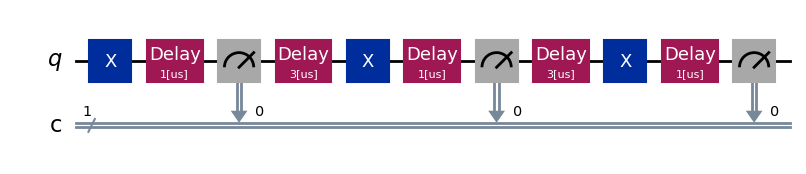

In [2]:
import utils # auxiliary script to create the circuit and avoid unusful info

num_qubits = 1
qc = utils.create_example_circuit(num_qubits)

# drawing the circuit
qc.draw('mpl')

<span style="color: grey;">

*The previous circuit is not correct because we only considered one classic register and the results of the measurements will be overwritten.*

*Moreover, at the current date **qmio does not support intermediate meassurements** so a circuit like the previous one (even with a classical register for each measurement) woudn't be supported by qmio.*

</span>

Some problems we face with this new approach is that we need to study if there is an **asymmetry** between the transitions $|0 \rangle \rightarrow |1 \rangle$ and $|1 \rangle \rightarrow |0 \rangle$. 

Even if this transitions are symmetrical when nothing external perturbes the performance of the qubits (which may not be true), in [1] an asymmetry was found when measuring the impact of ambiental radiation. That is, when we started the circuit implementing the state $| 1 \rangle$ (that is, applying an X gate), the impact of this radiation produces quasiparticles in the chip that make the state go back to $|0 \rangle$, but the contrary is not found because these quasiparticles don't have enough energy to excitate the $ |0 \rangle$ state to go to $| 1 \rangle$. More information about the physical process the quasiparticles go through is available in the complementary information of [1].

We are working with different qubit architectures so this may not be true, but in order to find if it is true or not we need to make the measurement.

Why is this measurement important? If we try to implement a similar circuit to the one we found above, the workflow would be as follows:

1. First iteration: We start with $|0 \rangle $, apply X and get $|1 \rangle$. If a cosmic ray perturbes the state, we would measure a $|0 \rangle$ instead of a $|1\rangle$ for some qubits.
2. Second iteration: We don't let the state go back to $|0 \rangle$, so in principle if no perturbation occurs, after applying the X gate we expect to measure $|0 \rangle$, what happens in this case if a cosmic ray impacts the chip ? It may not perturbe the qubits since it may not have enough energy to make the transition $|0\rangle \rightarrow |1\rangle$.

And for this reason we need to find if there is an asymmetry between these transitions before implementing the circuit. 

### **Code : Version 1 (v1).**

In order to measure the asymmetry we are going to implement the following circuit:

1. Initialize all qubits at state $|1 \rangle$ ( $|0 \rangle$ )
2. Wait $5 \ T_1 = 500 \ \mu s$.
3. Measure the state of all qubits. 

From [1] we are expecting the impact of cosmic rays to perturbe the states of the qubits for $\sim \ 25 \ ms$, so in principle with this waiting time we can still see if a cosmic ray perturbed the state of the qubits.

#### **Version v1.0.**

The first try of this new algorithm implementation was **v1.0**. The basic idea is the following one:

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import time

num_qubits = 5

#backend = FakeQmio(gate_error = True, readout_error = True)
backend = AerSimulator()

qc = QuantumCircuit(num_qubits, num_qubits)

# ----- circuit definition ------
qc.x(range(num_qubits)) # applying x gate: |0> -> |1>
qc.delay(1, range(num_qubits), unit='us')  # delay of  1 µs
qc.measure(range(num_qubits), range(num_qubits))

qct = transpile(qc, backend)

num_repetitions = 10

start_time = time.time() #initial time t = 0

for i in range(num_repetitions):
    result = backend.run(qct, shots=1).result()
    counts = result.get_counts(qct)

    # absolute time between measurements ?
    absolute_time = time.time() - start_time
    print('counts:', counts, 'time:', absolute_time)

counts: {'11111': 1} time: 0.0008599758148193359
counts: {'11111': 1} time: 0.0013701915740966797
counts: {'11111': 1} time: 0.0020940303802490234
counts: {'11111': 1} time: 0.0025091171264648438
counts: {'11111': 1} time: 0.002888917922973633
counts: {'11111': 1} time: 0.0032591819763183594
counts: {'11111': 1} time: 0.003717184066772461
counts: {'11111': 1} time: 0.004130125045776367
counts: {'11111': 1} time: 0.004499912261962891
counts: {'11111': 1} time: 0.00485992431640625


What we see by running the previous code **with FakeQmio backend is that the time between measurements is of around 0.3s...** Relevant to us ?? It seems like the execution time of the circuit is of that order but we are using here the ```FakeQmio```backend, which is not important for our final measurement.

#### **Version v1.1.**

The next attempt of the implementation is **v1.1**.

To implement this circuit we have taken into account the following attributes of the *run* method provided by ```qmiotools``` module.

- ```repetition_period``` : We have already talked about the necessity of including this attribute. It allows you to repeat a certain circuit a numer of times *n_shots* in an interval time given by *repetition_period* s. If the execution time of the circuit is bigger than the *repetition_period* interval, an error arises.
  
  <img src="repetition_period.png" alt="Repetition period diagram" width="500">
- ```memory``` : The memory atribute is the one that allows you to save the result of the measurement done in each repetition (*shot*).

Considering this the new attempt of implementing the code is similar to the following one:

In [ ]:
from qiskit import QuantumCircuit, transpile
from qmiotools.integrations.qiskitqmio import FakeQmio
import time

# number of qubits
num_qubits = 5

backend = FakeQmio(gate_error = True, readout_error = True)

qc = QuantumCircuit(num_qubits, num_qubits)

# ---- circuit definition -----
qc.x(range(num_qubits)) # applying x gate: |0> -> |1>
qc.delay(1, range(num_qubits), unit='us')  # delay of  1 µs
qc.measure(range(num_qubits), range(num_qubits)) # this operation takes about 5 µs

qct = transpile(qc, backend)

#------ circuit execution ------
n_repetitions = 1000 ; repetition_period = 0.001 #in s

start_time = time.time() #initial time t = 0

n_shots = n_repetitions
result = backend.run(qct, shots=n_repetitions, repetition_period = repetition_period, memory = True).result()  
memory = result.get_memory(qct)

# absolute time the circuit lasted
absolute_time = time.time() - start_time

#----- results ----
print('The absolute exectution time was: ', absolute_time)
print('The theoretical exectution time is: ', n_repetitions*repetition_period)
print('memory:\n', memory)


with open("results1.txt", "a") as f:
    f.write("Repetition\tState\n")
    for (i,state) in enumerate(memory):
        f.write(f"{i + 1}\t{state}\n")

What we saw by running the previous code with the FakeQmio backend is that the execution time is invariant to the change of the *repetition_period* time. That probably means that this *repetition_period* is not implemented for the FakeQmio backend, and we need to promote the execution of the codes to the real qpu.

### Bibliografy.

[1] Matt McEwen et all. Resolving catastrophic error bursts from cosmic rays in large arrays of superconducting qubits. Nature Physics, 18(1):107–111, 2022.